## Cats and Dogs 이진분류

### 이진분류 프로젝트

#### 개요
- 목표 : CNN으로 개와 고양이 이미지 분류 이진 분류기

#### Kaggle 데이터 다운로드
- 캐글이란?
    - https://www.kaggle.com/
    - 예측모델 및 분석 대회 플랫폼. 2017년 구글이 인수

1. Kaggle 계정 만들기
2. 설정 진입
    - https://www.kaggle.com/settings
    - API > Create New Token 클릭 kaggle.json 다운로드

3. 파이썬 Kaggle 패키지 설치
    ```shell
    ! pip install kaggle
    ```

4. kaggel.json 파일 위치
    - 리눅스/유닉스 : ~/.kaggle/kaggle.json
    - 윈도우 : %USERPROFILE%\.kaggle
        - 사용자 폴더 아래
    - 다운로드로 받은 kaggle.json을 붙여넣기

5. https://www.kaggle.com/competitions/dogs-vs-cats/overview 진입
    - Data 탭에서 Join the competition 클릭

In [1]:
!pip install kaggle

  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/173.2 kB ? eta -:--:--
   ----------------------------------- ---- 153.6/173.2 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 173.2/173.2 kB 2.6 MB/s eta 0:00:00
Using cached bleach-6.2.0-py3-none-any.whl (163 kB)
   ---------------------------------------- 0.0/78.2 kB ? eta -:--:--
   ---------------------------------------- 78.2/78.2 kB 4.2 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 데이터셋 다운로드
!kaggle competitions download -c dogs-vs-cats

403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/competitions/data/download-all/dogs-vs-cats


#### 데이터셋 전처리

In [3]:
# 파이썬 모듈로드
import os, shutil, random

In [ ]:
# 500개씩 샘플링 함수
def sample_data(src_dir, dst_dir, num_samples=500):
    os.makedirs(dst_dir, exist_ok=True)     # 폴더 생성, exist_ok=True는 이미 존재하면 다시 만들지 않음
    all_files = [f for f in os.listdir(src_dir) if f.startswith(dst_dir.split('/')[-1])]
    samples = random.sample(all_files, num_samples)
    for f in samples:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir, f))

In [9]:
# 폴더 정리
base_dir = './data/train'   # 원본폴더 25000개
cat_dir = './data/sample/cat'
dog_dir = './data/sample/dog'

In [10]:
os.makedirs('./data/sample/cat', exist_ok=True)
os.makedirs('./data/sample/dog', exist_ok=True)

In [11]:
# sample_data() 함수 사용
sample_data(base_dir, cat_dir, 500)
sample_data(base_dir, dog_dir, 500)

<img src="../image/ml0021.png" with="700">

#### 파이토치 시작!

- ImageFolder 클래스 - 폴더명을 자동으로 레이블로 변환
    - cat -> 0, dog -> 1

In [12]:
# 파이토치 모듈 로드
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [13]:
# 
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [39]:
train_dataset = ImageFolder('./data/sample', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#### train_loader 시각화

In [15]:
# 시각화용 모듈 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
# 한글로 Matplotlib 사용시 항상 필요!
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf' # 맑은고딕체로 변경
font = font_manager.FontProperties(fname=font_path).get_name() # 실제 설치된 폰트 이름조회
rc('font', family=font) # 한글깨짐현상 해결!!
rcParams['axes.unicode_minus'] = False # 한글 사용시 마이너스 표시 깨짐 해결!

# 시본 형태로 차트 변경
sns.set_style('darkgrid')
sns.set_theme(font='Malgun Gothic', rc={'axes.unicode_minus': False})

In [17]:
# 배치하나 꺼내기
images, labels = next(iter(train_loader))

In [31]:
class_names = ['cat', 'dog']

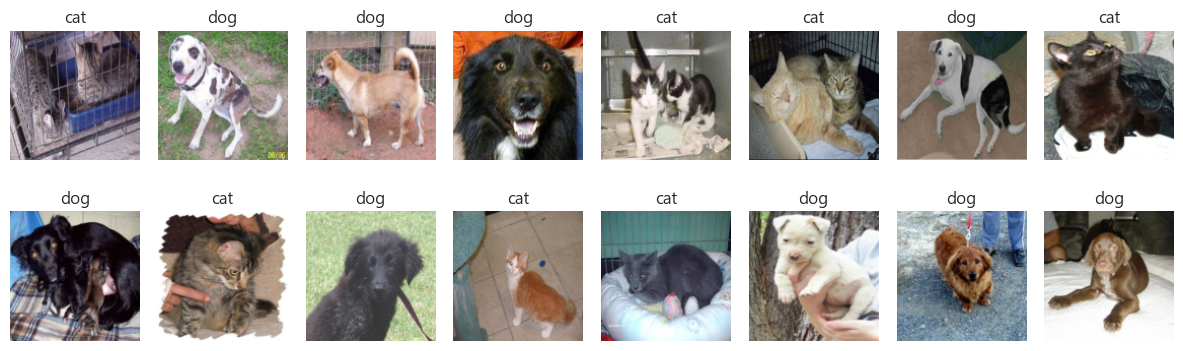

In [40]:
# 시각화
plt.figure(figsize=(12, 4))
for i in range(16):     # 32개 중 반만 표현현
    plt.subplot(2, 8, i+1)

    img = images[i].permute(1, 2, 0)    # 컬러 채널이기 때문에 matplotlib 표현시 순서 변경
    plt.imshow(img)
    plt.title(f'{class_names[labels[i].item()]}')
    plt.axis('off')

plt.tight_layout()

#### CNN 모델정의

In [42]:
# 사용모듈 로드
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# 클래스 정의
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # conv1, conv2 모두 사용
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)    # MaxPool(128) -> MaxPool(64) -> 32x32
        self.fc2 = nn.Linear(128, 1)    # 마지막 분류가 0, 1

    def forward(self, x):
        # conv -> activation -> maxpooling 2회 실시
        # dense1, 2 통과
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x= x.view(-1, 64 * 32 * 32)             # flattern -> 1차원 배열화. 65,536개 입력 
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))              # F.sigmoid() deprecated
        return x

#### 훈련

In [49]:
# cuda 준비
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CatDogCNN().to(device)
criterion = nn.BCELoss()    # Binary Cross Entropy 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [50]:
# 훈련함수
def train(model, loader, criterion, optimizer):
    model.train()   # 훈련모드
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)  # 1, 0 -> [1,], [0,]
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader) 

In [52]:
# 훈련
EPOCH = 10
for epoch in range(EPOCH):
    loss = train(model, train_loader, criterion, optimizer)
    print(f'[{epoch+1}/{EPOCH}] Loss: {loss:.4f}')

[1/10] Loss: 0.4039
[2/10] Loss: 0.3386
[3/10] Loss: 0.2606
[4/10] Loss: 0.1654
[5/10] Loss: 0.0951
[6/10] Loss: 0.0520
[7/10] Loss: 0.0340
[8/10] Loss: 0.0154
[9/10] Loss: 0.0071
[10/10] Loss: 0.0040


#### 예측결과 시각화

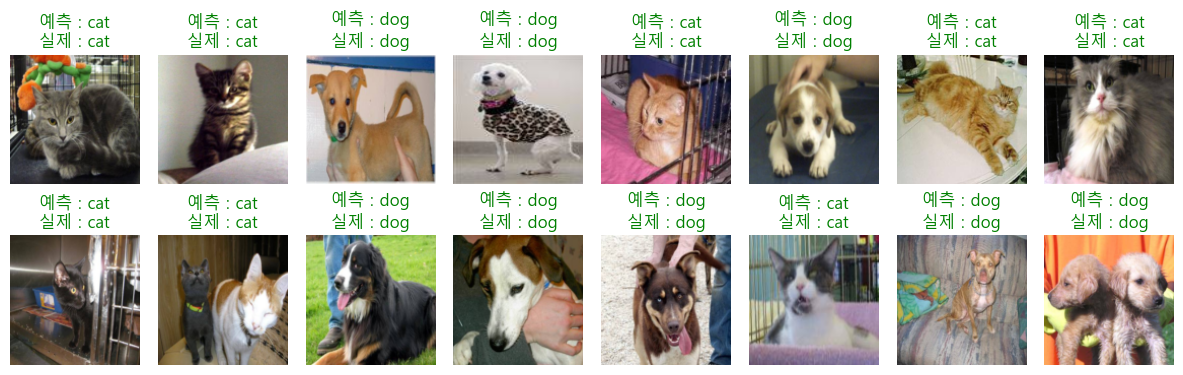

In [63]:
# 검증
model.eval()
images, labels = next(iter(train_loader))
images = images.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = (outputs > 0.5).int().cpu().squeeze()

plt.figure(figsize=(12, 4))
for i in range(16):
    plt.subplot(2, 8, i + 1)
    plt.imshow(images[i].cpu().permute(1, 2, 0))
    pred_label = 'dog' if preds[i] == 1 else 'cat'
    true_label = 'dog' if labels[i] == 1 else 'cat'
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'예측 : {pred_label}\n실제 : {true_label}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 모델저장/불러오기

In [65]:
# 가중치만 저장
torch.save(model.state_dict(), './catdog_weight.pth')

In [66]:
# 모델 전체 저장
torch.save(model, './catdog_model.pth')

In [68]:
# 가중치만 불러올 때
model2 = CatDogCNN().to(device)
model2.load_state_dict(torch.load('./catdog_weight.pth', map_location=device))
model2

CatDogCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

#### 테스트 이미지로 테스트
- 1.jpg ~ 12500.jpg 까지 Dog, Cat 구분하기

In [70]:
# 필요 모듈 로드
import torch
from torchvision import transforms
from PIL import Image

In [85]:
# transform은 위에 선언함

img = Image.open('./data/test/2567.jpg').convert('RGB')
img_tensor = transform(img).unsqueeze(0)    # [3, 128, 128] -> [1, 3, 128, 128] 4차원 텐서로 변경
print(img_tensor)
img.show()  # 기본 이미지 뷰 프로그램으로 표현

tensor([[[[0.4588, 0.4902, 0.5569,  ..., 0.9961, 0.9961, 0.9961],
          [0.4627, 0.4745, 0.5490,  ..., 0.9961, 0.9961, 0.9922],
          [0.4902, 0.4745, 0.5529,  ..., 0.9961, 0.9961, 0.9882],
          ...,
          [0.2588, 0.3059, 0.5961,  ..., 0.8706, 0.8000, 0.7804],
          [0.2784, 0.3216, 0.5882,  ..., 0.8745, 0.8353, 0.7804],
          [0.3922, 0.4000, 0.6118,  ..., 0.8824, 0.8392, 0.7608]],

         [[0.4549, 0.4824, 0.5490,  ..., 0.9961, 0.9961, 0.9961],
          [0.4588, 0.4706, 0.5412,  ..., 0.9961, 0.9961, 0.9922],
          [0.4863, 0.4667, 0.5451,  ..., 0.9961, 0.9961, 0.9882],
          ...,
          [0.2235, 0.2588, 0.5686,  ..., 0.8745, 0.8000, 0.7843],
          [0.2471, 0.2784, 0.5608,  ..., 0.8784, 0.8392, 0.7922],
          [0.3686, 0.3608, 0.5843,  ..., 0.8863, 0.8431, 0.7725]],

         [[0.4431, 0.4784, 0.5569,  ..., 0.9961, 0.9961, 0.9961],
          [0.4431, 0.4667, 0.5490,  ..., 0.9961, 0.9961, 0.9922],
          [0.4706, 0.4627, 0.5529,  ..., 0

In [84]:
# model

In [86]:
model.eval()    # 예측, 평가 모드로

with torch.no_grad():
    output = model(img_tensor.to(device))
    pred = (output > 0.5).int().item()

'Dog' if pred == 1 else 'Cat'

'Dog'

#### 폴더로 여러개 테스트

In [87]:
test_dir = './data/test'
image_files = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))]

In [88]:
len(image_files)

12500

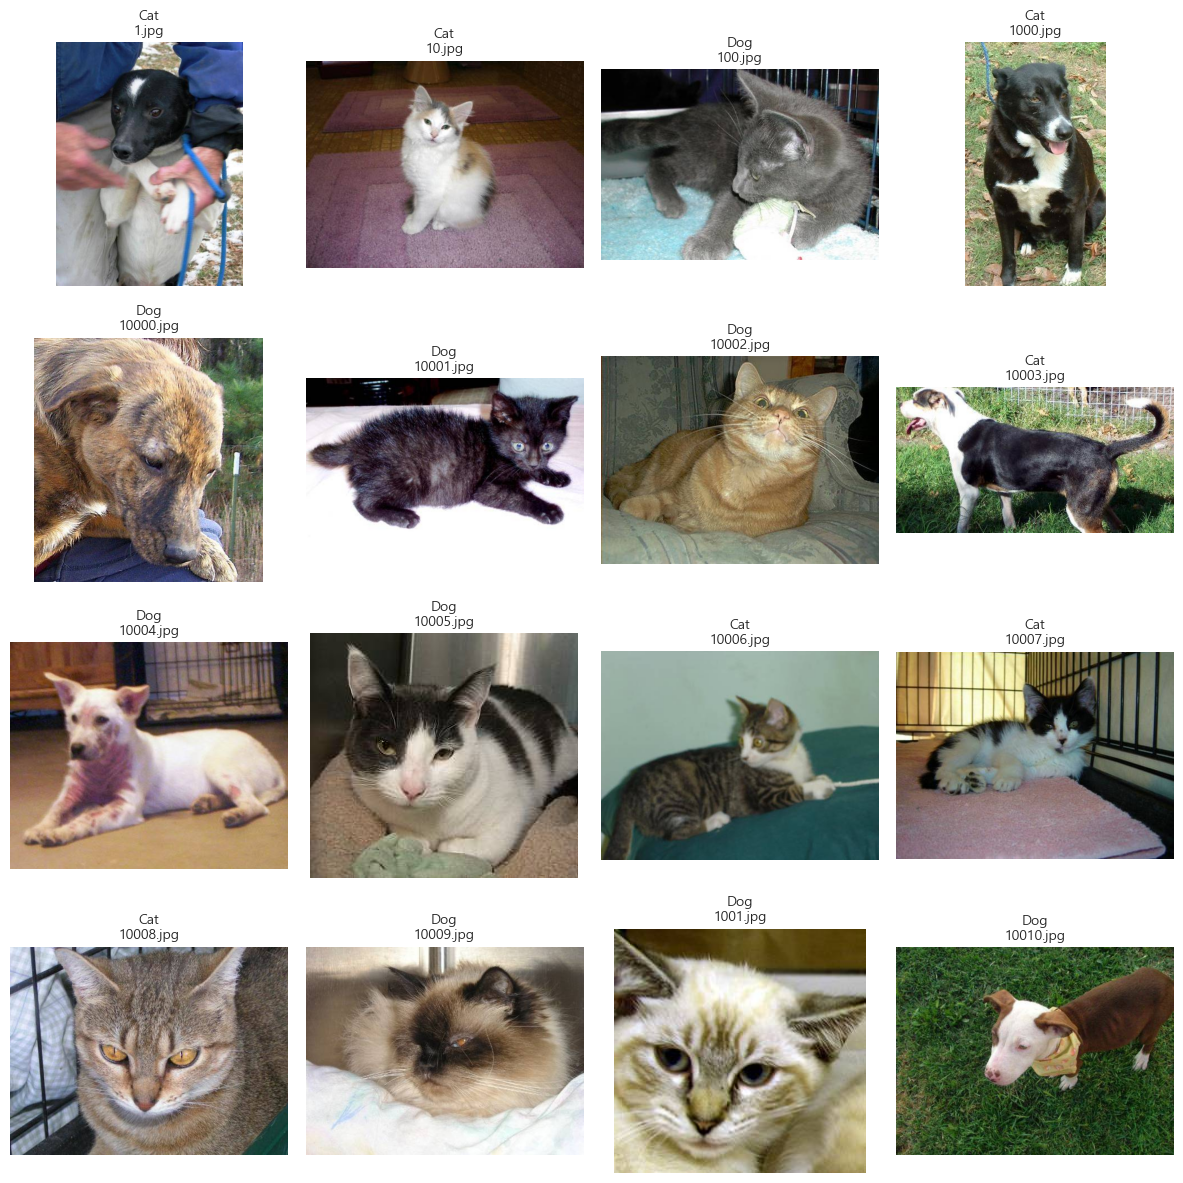

In [89]:
# 예측과 시각화 동시
plt.figure(figsize=(12, 12))
for i, fname in enumerate(image_files[0:16]):  # 최대 16장까지 출력 0:16, 16:32, 32:48
    img_path = os.path.join(test_dir, fname)
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        pred = 'Dog' if output.item() > 0.5 else 'Cat'

    # 이미지 출력
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(f'{pred}\n{fname}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Kaggle Competitions 도전

- 캐글상에선 경로 등이 윈도우와 다르기 때문에 설정 변경 필요

#### 캐글 노트북
1. Data > Join the Competition 클릭
2. Code > New Notebook 클릭 (코랩과 동일한 방식)
3. 노트북 작성
4. 캐글 서버내 압축파일 처리부분만 새로 코딩
5. 위의 소스 그대로 사용가능
6. submission.csv 만드는 코드 추가
7. submission.csv 제출

#### 캐글 GPU
- 캐글 노트북 Settings > Accerlerator > GPU T4 x2, GPU P1000 으로 GPU 사용가능(1주일에 30시간 제한)